# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. These are color images of different classes, such as airplanes, dogs or trucks. This dataset is much more complex and diverse than the MNIST dataset and justifies the use of the DCGAN architecture.

<p align="center">
    <img src='../../images/cifar10_data.png' width="500" height="auto"/>
</p>


So, our goal is to create a DCGAN that can generate new, realistic-looking images. We'll go through the following steps to do this:
* **Load in and pre-process the CIFAR10 dataset**
* Define discriminator and generator networks
* **Train these adversarial networks**
* **Visualize the loss over time and some sample, generated images**

In this notebook, we will focus on defining the networks.

#### Deeper Convolutional Networks

Since this dataset is more complex than our MNIST data, we'll need a deeper network to accurately identify patterns in these images and be able to generate new ones. Specifically, we'll use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train. 

Besides these changes in network structure, training the discriminator and generator networks should be the same as before. That is, the discriminator will alternate training on real and fake (generated) images, and the generator will aim to trick the discriminator into thinking that its generated images are real!

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

## Getting the data

Here you can download the CIFAR10 dataset. It's a dataset built-in to the PyTorch datasets library. We can load in training data, transform it into Tensor datatypes, then create dataloaders to batch our data into a desired size.

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# CIFAR training datasets
cifar_train = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)

batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)

Files already downloaded and verified


### Visualize the Data

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real, training images that we'll pass to the discriminator. Notice that each image has _one_ associated, numerical label.

<Figure size 2500x400 with 0 Axes>

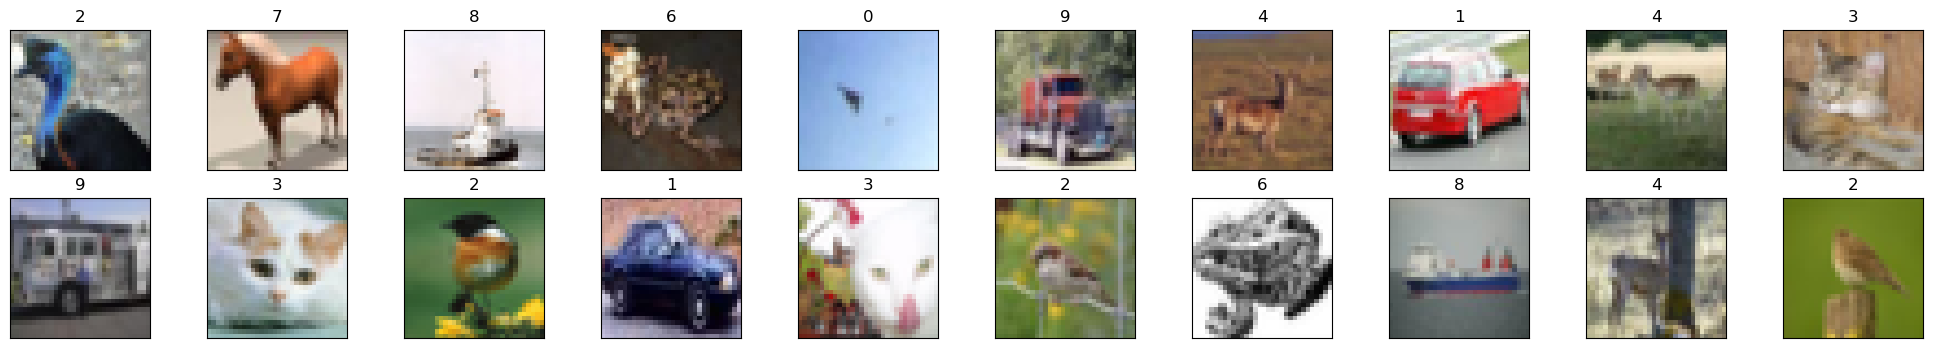

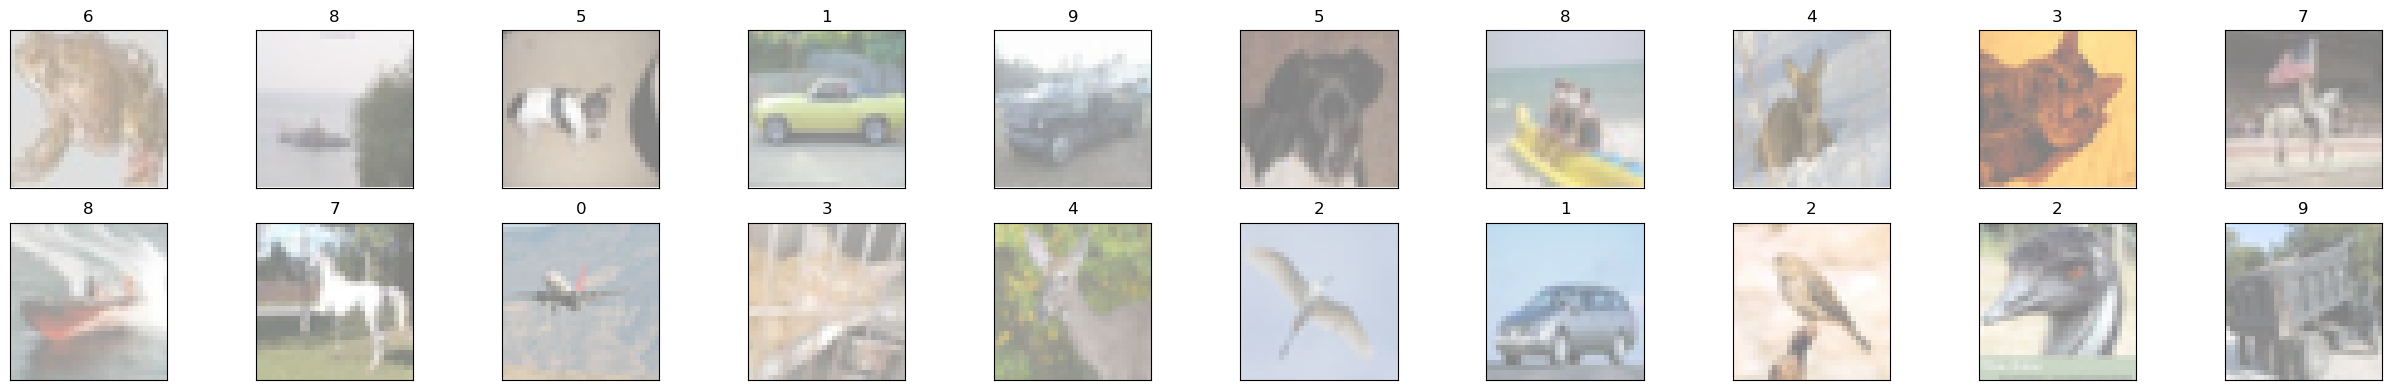

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size = 20  # Should be even number for this grid layout


"""Visualizes a batch of training images with labels in a 2-row grid.

Args:
    train_loader: PyTorch DataLoader yielding (images, labels) batches
    plot_size: Number of images to display (must be even)

Process:
    1. Extracts one batch of (images, labels)
    2. Creates 2xN subplot grid (N = plot_size//2)
    3. For each image:
       - Converts tensor to numpy array
       - Transposes dimensions (C,H,W → H,W,C)
       - Denormalizes pixels ([-1,1] → [0,1])
    4. Displays final figure with tight layout

Note: Assumes images were normalized with mean=0.5, std=0.5
"""
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
    # Convert tensor to numpy and transpose dimensions
    img = np.transpose(images[idx].numpy(), (1, 2, 0))
    # If normalized, denormalize (assuming mean=0.5, std=0.5)
    img = img * 0.5 + 0.5  # Scale from [-1,1] to [0,1]
    ax.imshow(img)
    ax.set_title(str(labels[idx].item()))
    
plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.1804)
Max:  tensor(0.8863)


In [ ]:
def scale(x, feature_range=(-1, 1)):
    """Scales input tensor from [0,1] range to specified feature range.
    
    Args:
        x (torch.Tensor or numpy.ndarray): Input tensor/image normalized [0,1]
        feature_range (tuple): Desired output range (min, max). Default (-1, 1)
        
    Returns:
        Scaled tensor of same type as input
        
    Example:
        >>> scaled = scale(img_tensor)  # Scales from [0,1] to [-1,1]
        >>> custom_scaled = scale(img_tensor, (0, 255))  # Scales to [0,255]
        
    Note:
        Assumes input is already in [0,1] range. For image tensors, 
        typically applied after ToTensor() normalization.
    """
    min_val, max_val = feature_range
    x = x * (max_val - min_val) + min_val
    return x


In [9]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.6392)
Scaled max:  tensor(0.7725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. Let's use the models we created in the previous exercise.

#### Discriminator

Here you'll build the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
* The inputs to the discriminator are 32x32x3 tensor images
* You'll want a few convolutional, hidden layers
* Then a fully connected layer for the output; as before, we want a sigmoid output, but we'll add that in the loss function, [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), later


In [ ]:
import torch.nn as nn


class ConvBlock(nn.Module):
    """A modular convolutional block implementing Conv2d → BatchNorm → LeakyReLU.
    
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of kernels/filters in the conv layer
        - kernel_size: kernel size of the conv layer
        - batch_norm: whether to use batch norm or not
        
    This block encapsulates a common pattern used in DCGAN architectures, providing
    consistent downsampling behavior through strided convolutions.

    Attributes:
        - conv (nn.Conv2d): 2D convolutional layer with stride=2 for downsampling
        - bn (nn.BatchNorm2d): Optional batch normalization layer
        - activation (nn.LeakyReLU): LeakyReLU activation with negative slope=0.2

    Args:
        - in_channels (int): Number of input channels
        - out_channels (int): Number of output channels/filters
        - kernel_size (int): Size of convolutional kernel (assumed square)
        - batch_norm (bool): Whether to include batch normalization. Default True.

    Input:
        x (torch.Tensor): 4D input tensor of shape (batch, channels, height, width)

    Returns:
        torch.Tensor: 4D output tensor with:
            - Channels: out_channels
            - Spatial dimensions halved (due to stride=2)
            - BatchNorm applied if enabled
            - LeakyReLU activation

    Example:
        >>> block = ConvBlock(64, 128, 4)
        >>> out = block(torch.randn(32, 64, 32, 32))  # Output shape: [32, 128, 16, 16]

    Note:
        - Uses stride=2 and padding=1 for consistent downsampling
        - Bias disabled in conv when using batch norm (standard practice)
        - Follows DCGAN conventions (LeakyReLU slope=0.2)
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                             stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x


class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten
        x = self.flatten(x)
        # final output layer
        x = self.fc(x)        
        return x

## Generator

Next, you'll build the generator network. The input will be our noise vector `z`, as before. And, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our CIFAR10 images.

In [13]:
class DeconvBlock(nn.Module):
    """A transposed convolutional block implementing ConvTranspose2d → BatchNorm → ReLU.
    
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    
    args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - stride: stride of the conv layer
        - padding: padding of the conv layer
        - batch_norm: whether to use batch norm or not
        
    This block encapsulates the generator's upsampling pattern in DCGAN architectures,
    providing consistent feature map expansion through strided transposed convolutions.

    Attributes:
        deconv (nn.ConvTranspose2d): Transposed conv layer for upsampling
        bn (nn.BatchNorm2d): Optional batch normalization layer
        activation (nn.ReLU): ReLU activation function

    Args:
        in_channels (int): Number of input channels
        out_channels (int): Number of output channels/filters  
        kernel_size (int): Size of transposed convolutional kernel
        stride (int): Stride for upsampling (typically 2)
        padding (int): Padding amount (typically 1 for kernel_size=4)
        batch_norm (bool): Whether to include batch normalization. Default True.

    Input:
        x (torch.Tensor): 4D input tensor of shape (batch, channels, height, width)

    Returns:
        torch.Tensor: 4D output tensor with:
            - Channels: out_channels
            - Spatial dimensions multiplied by stride
            - BatchNorm applied if enabled  
            - ReLU activation

    Example:
        >>> block = DeconvBlock(256, 128, 4, stride=2, padding=1)
        >>> out = block(torch.randn(32, 256, 4, 4))  # Output shape: [32, 128, 8, 8]

    Note:
        - Standard DCGAN configuration uses kernel_size=4, stride=2, padding=1
        - Bias disabled when using batch norm (standard practice)
        - Uses ReLU activation (standard for generator in DCGAN)
        - Output size formula: H_out = (H_in - 1)*stride - 2*padding + kernel_size
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, 
                 stride: int, padding: int, batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                       stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x


class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 32):
        super(Generator, self).__init__()
        # transpose conv layers
        self.deconv1 = DeconvBlock(latent_dim, conv_dim*4, 4, 1, 0)
        self.deconv2 = DeconvBlock(conv_dim*4, conv_dim*2, 4, 2, 1)
        self.deconv3 = DeconvBlock(conv_dim*2, conv_dim, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1)
        self.last_activation = nn.Tanh()
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.last_activation(x)
        return x
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(latent_dim=z_size, conv_dim=conv_dim)

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 
> Later, we'll also move any inputs our models and loss functions see (real_images, z, and ground truth labels) to GPU as well.

In [15]:
# Check available devices
device = torch.device('cuda' if torch.cuda.is_available() else 
                     'mps' if torch.backends.mps.is_available() else 
                     'cpu')

# Move models to appropriate device
G.to(device)
D.to(device)

# Print device status
if device.type == 'cuda':
    print('GPU available for training. Models moved to CUDA')
elif device.type == 'mps':
    print('Apple MPS available. Models moved to MPS device')
else:
    print('Training on CPU.')
    

Apple MPS available. Models moved to MPS device


---
## Discriminator and Generator Losses

Now we need to calculate the losses. And this will be exactly the same as before.

### Discriminator Losses

For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.  Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the real images with a label = 1, indicating that these are real. The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

---
#### Binary Cross-Entropy Loss with Logits in GAN Training

##### Understanding BCEWithLogitsLoss

The `BCEWithLogitsLoss` function represents a fundamental component in GAN training that combines two essential operations: the sigmoid activation function and binary cross-entropy loss computation. This combination proves both computationally efficient and numerically stable, making it the preferred choice for binary classification tasks in deep learning.

##### Mathematical Foundation

To understand why `BCEWithLogitsLoss` exists, we need to examine the traditional approach to binary classification. Conventionally, you would apply a sigmoid function to convert raw logits into probabilities, then compute the binary cross-entropy loss:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\text{BCE}(y, \hat{y}) = -[y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$

Where $y$ is the true label (0 or 1) and $\hat{y}$ is the predicted probability.

However, `BCEWithLogitsLoss` combines these operations using the mathematically equivalent but more stable formulation:

$$\text{BCEWithLogits}(x, y) = \max(x, 0) - x \cdot y + \log(1 + e^{-|x|})$$

This formulation avoids the numerical instabilities that can occur when computing $\log(\sigma(x))$ for very large or very small values of $x$.

##### Why This Matters for GANs

In GAN training, both the discriminator and generator require stable gradient computation for effective learning. The discriminator outputs raw logits (unbounded values) rather than probabilities, and these logits can become quite large during training. Using `BCEWithLogitsLoss` prevents numerical overflow and underflow issues that could destabilize training.

##### Discriminator Loss Components

The discriminator's objective involves two distinct classification tasks that must be balanced carefully.

##### Real Image Loss

For real images, the discriminator should output high logits (approaching positive infinity in the ideal case). The loss function encourages this behavior:

```python
# Real images should be classified as real (label = 1)
real_labels = torch.ones(batch_size, device=device)
real_logits = discriminator(real_images)
d_real_loss = criterion(real_logits, real_labels)
```

When the discriminator correctly identifies real images (high positive logits), this loss approaches zero. When it incorrectly classifies real images as fake (negative logits), the loss increases significantly.

##### Fake Image Loss

For fake images generated by the generator, the discriminator should output low logits (approaching negative infinity). The corresponding loss term encourages this discrimination:

```python
# Fake images should be classified as fake (label = 0)
fake_labels = torch.zeros(batch_size, device=device)
fake_images = generator(noise)
fake_logits = discriminator(fake_images.detach())  # detach to prevent generator gradients
d_fake_loss = criterion(fake_logits, fake_labels)
```

The `.detach()` operation proves crucial here. It prevents gradients from flowing back to the generator during discriminator training, ensuring that only the discriminator's parameters are updated in this phase.

##### Combined Discriminator Loss

The total discriminator loss represents the sum of both components:

```python
d_loss = d_real_loss + d_fake_loss
```

This formulation encourages the discriminator to simultaneously excel at two tasks: recognizing real images as real and identifying fake images as fake.

##### Generator Loss: The Adversarial Flip

The generator's loss function demonstrates the elegant adversarial nature of GAN training. While the discriminator tries to distinguish real from fake, the generator attempts to fool the discriminator completely.

##### The Label Flipping Strategy

The generator's objective involves a conceptual "label flip." Instead of trying to minimize the probability that its outputs are classified as fake, it maximizes the probability that they are classified as real:

```python
# Generator wants fake images to be classified as real (label = 1)
real_labels = torch.ones(batch_size, device=device)
fake_images = generator(noise)
fake_logits = discriminator(fake_images)  # No detach() here!
g_loss = criterion(fake_logits, real_labels)
```

Notice the absence of `.detach()` in the generator loss computation. This allows gradients to flow from the discriminator's output back through the generator's parameters, enabling the generator to learn how to produce images that fool the discriminator.

##### The Minimax Game in Practice

This loss formulation implements the theoretical minimax game described in the original GAN paper. The discriminator maximizes:

$$\mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1-D(G(z)))]$$

While the generator minimizes:

$$\mathbb{E}_{z \sim p_z}[\log(1-D(G(z)))]$$

In practice, the generator often minimizes $-\mathbb{E}_{z \sim p_z}[\log D(G(z))]$ instead, which corresponds exactly to our label-flipped `BCEWithLogitsLoss` formulation.

##### Training Dynamics and Convergence

The interplay between discriminator and generator losses creates a dynamic equilibrium. Early in training, the discriminator typically dominates, easily distinguishing between real and fake images. As training progresses, the generator improves, making the discriminator's task more challenging.

The ideal convergence point occurs when the discriminator can no longer distinguish between real and fake images, outputting probability 0.5 for all inputs. At this Nash equilibrium, both losses stabilize, and the generator has learned to approximate the real data distribution.

```mermaid
flowchart TD
    RealImages["Real Images<br>x ~ p_data"] --> D1["Discriminator<br>D(x)"]
    D1 --> RealLogits["Real Logits<br>(should be high)"]
    RealLogits --> RealLoss["Real Loss<br>BCE(logits, 1)"]
    
    Noise["Random Noise<br>z ~ N(0,1)"] --> Generator["Generator<br>G(z)"]
    Generator --> FakeImages["Fake Images<br>G(z)"]
    
    FakeImages --> D2["Discriminator<br>D(G(z))"]
    D2 --> FakeLogits["Fake Logits"]
    
    FakeLogits --> FakeLossD["Discriminator Loss<br>BCE(logits, 0)"]
    FakeLogits --> FakeLossG["Generator Loss<br>BCE(logits, 1)"]
    
    RealLoss --> DTotal["Total D Loss<br>Real + Fake"]
    FakeLossD --> DTotal
    
    style RealImages fill:#BCFB89
    style Noise fill:#BCFB89
    style Generator fill:#9AE4F5
    style FakeImages fill:#FBF266
    style D1 fill:#FA756A
    style D2 fill:#FA756A
    style RealLoss fill:#0096D9
    style FakeLossD fill:#0096D9
    style FakeLossG fill:#FCEB14
    style DTotal fill:#FE9237
```

##### Practical Implementation Considerations

When implementing GAN training with `BCEWithLogitsLoss`, several practical considerations emerge. The relative strength of discriminator and generator updates often requires careful balancing. If the discriminator becomes too powerful too quickly, it may provide vanishing gradients to the generator. Conversely, if the generator updates too aggressively, it might collapse to producing a limited variety of outputs.

Many practitioners employ techniques such as alternating update schedules, where the discriminator is updated once for every few generator updates, or vice versa. Others add noise to the discriminator's inputs or use label smoothing, where real labels are set to 0.9 instead of 1.0, to prevent overconfident discriminator predictions.

The choice of `BCEWithLogitsLoss` over separate sigmoid and BCE computations represents more than mere convenience. It embodies a fundamental principle of numerical stability that proves essential for the delicate balance required in adversarial training. This stability allows GANs to train effectively across a wide range of architectures and datasets, making them the powerful generative models we recognize today.

---
### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Not much new here, but notice how I am using a small learning rate and custom parameters for the Adam optimizers, This is based on some research into DCGAN model convergence.

### Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [ ]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

**Evaluation mode**

Notice that, when we call our generator to create the samples to display, we set our model to evaluation mode: `G.eval()`. That's so the batch normalization layers will use the population statistics rather than the batch statistics (as they do during training), *and* so dropout layers will operate in eval() mode; not turning off any nodes for generating samples.

In [ ]:
import pickle as pkl
from datetime import datetime

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [ ]:
# training hyperparams
num_epochs = 10

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images.detach())
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()